In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.__version__

'2.17.1'

Using tf.keras.utils.get_file load the image files into your storage with this link https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/train.zip
#

In [ ]:
# First we download the .zip file containing all the images
tf.keras.utils.get_file("/content/cifar10.zip",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/train.zip",
                        extract=True,
                        cache_subdir="/content")

'/content/cifar10.zip'

Import the dataframe containing the labels from this link https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/trainLabels.csv

In [ ]:
# Then the DataFrame containing the name of the image files and the value of the
# target variable
import pandas as pd
data = pd.read_csv("https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/trainLabels.csv")
data.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


Turn the id column into string type and add .png at the end of each string for the filenames to be complete

In [ ]:
data["id"] = data["id"].astype("str") + ".png"
data.head()

,id,label
0,1.png,frog
1,2.png,truck
2,3.png,truck
3,4.png,deer
4,5.png,automobile


Load and display an image of your dataset

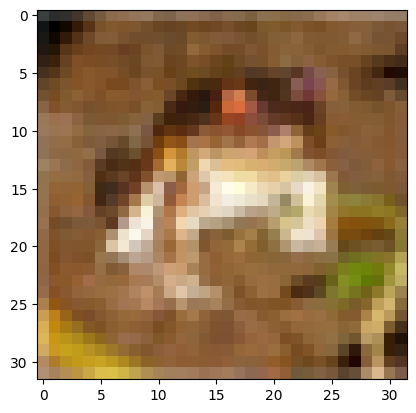

In [ ]:
# Visualize a random picture
img = tf.io.read_file("/content/train/1.png")
img = tf.image.decode_png(img, channels=3)
plt.imshow(img)

View a random image of each of your labels in your dataset

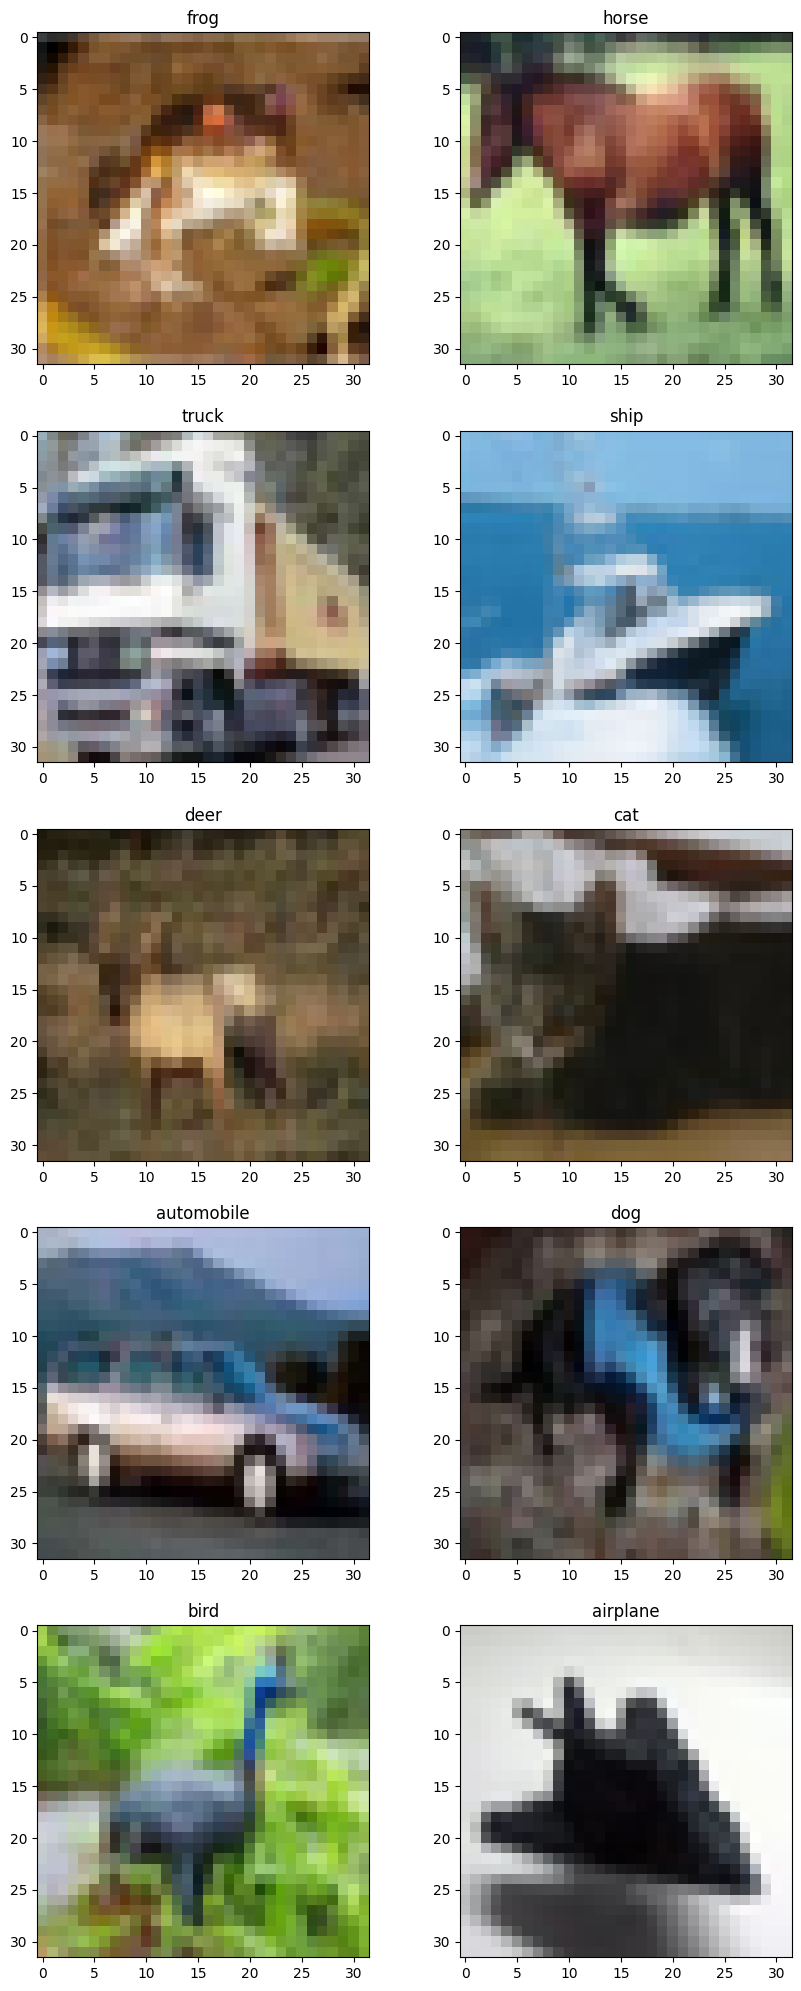

In [ ]:
data_per_label = data.loc[data["label"].duplicated()==False]
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,25))
for i in range(5):
  for j in range(2):
    filename = "/content/train/" + data_per_label.iloc[i+j*5,0]
    img = tf.io.read_file(filename)
    img = tf.image.decode_png(img, channels=3)
    axes[i,j].imshow(img)
    axes[i,j].title.set_text(data_per_label.iloc[i+j*5,1])

Define an instance of an ImageDataGenerator Class with the data augmentation parameters of your choice, and validation_split=0.3

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_generator = ImageDataGenerator(
    rotation_range=0, # Angle range for random image rotation
    width_shift_range=0.0, # Random shift of the image along width axis
    height_shift_range=0.0, # Random shift of the image along height axis
    brightness_range=(0.5,1), # Random brightness modification
    shear_range=0.0, # Random distortion of the image
    zoom_range=0.0, # Random zoom on the image
    channel_shift_range=50.0, # Random hue modification
    horizontal_flip=True, # Randomly flips image horizontally
    vertical_flip=True, # Randomly flips image virtically
    rescale=1/255., # Rescaling values from [0,255]->[0,1]
    fill_mode='wrap',
    validation_split=0.3 # Portion of the data that can be saved for validation
)

In [ ]:
train_generator = img_generator.flow_from_dataframe(
    dataframe=data, # the dataframe containing the filename and label column
    directory="/content/train", # the directory containing the image files
    x_col="id", # the name of the column with the filenames
    y_col="label", # the name of the column with the labels
    target_size=(32,32),
    class_mode = "sparse",
    batch_size=64,
    shuffle = True,
    subset = "training"
)

val_generator = img_generator.flow_from_dataframe(
    dataframe=data, # the dataframe containing the filename and label column
    directory="/content/train", # the directory containing the image files
    x_col="id", # the name of the column with the filenames
    y_col="label", # the name of the column with the labels
    target_size=(32,32),
    class_mode = "sparse",
    batch_size=64,
    shuffle = True,
    subset = "validation"
)

Found 35000 validated image filenames belonging to 10 classes.
Found 15000 validated image filenames belonging to 10 classes.


Display a batch of data of train data

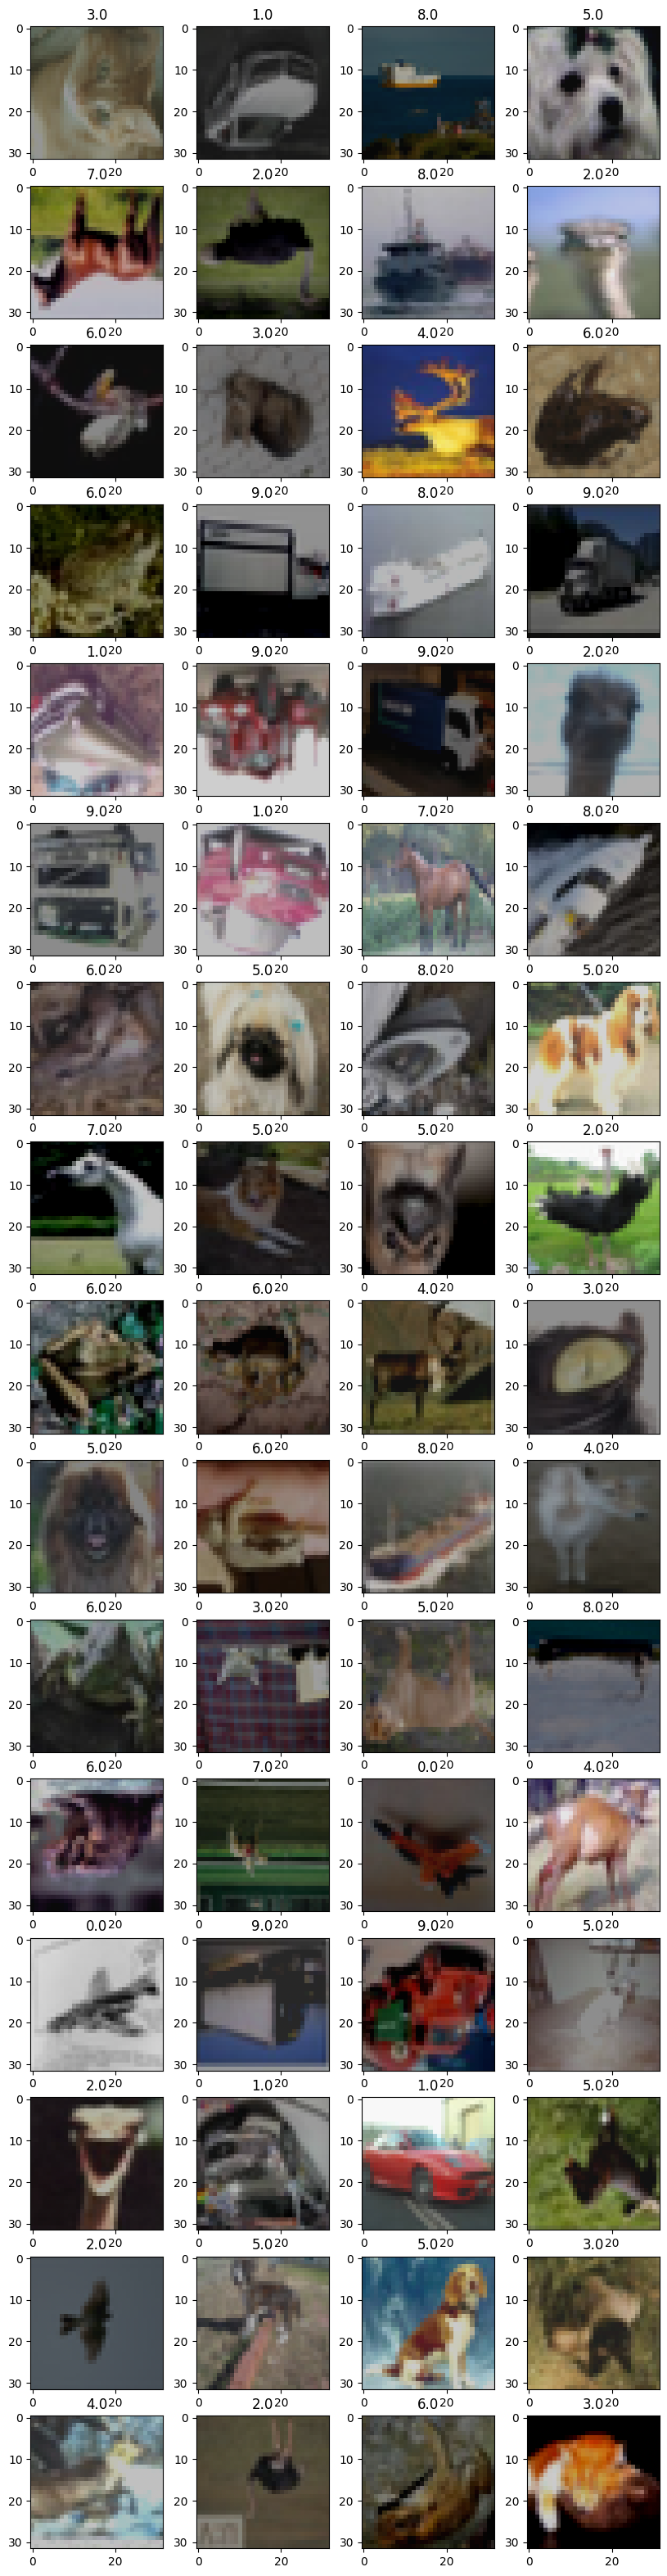

In [ ]:
imgs, targets = next(iter(train_generator))
fig, ax = plt.subplots(16,4, figsize=(10,40))
for i, (img, target) in enumerate(zip(imgs, targets)):
  ax[i-16*(i//16),i//16].imshow(img)
  ax[i-16*(i//16),i//16].title.set_text(str(target))
fig.show()

How many times can you divide the images by two along each axis until you reduce the images to single pixel?

In [ ]:
a = 32
while a>1 :
  print(a, "->" , a/2)
  a=a/2

32 -> 16.0
16.0 -> 8.0
8.0 -> 4.0
4.0 -> 2.0
2.0 -> 1.0


Build a neural network with a single convolution layer with 32 neurons, kernel size (3,3), padding "same", and activation "relu", a max pooling layer, a flatten layer, then finish up the network with a dense layer that can predict the target variable.

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential

# Définition du modèle convolutionnel
modelconv = tf.keras.Sequential([
    Conv2D(
        filters=32,
        kernel_size=(3, 3),
        padding="same",
        activation="relu",
        input_shape=(imgs.shape[1:])
    ),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation="softmax")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
imgs.shape

(64, 32, 32, 3)

In [ ]:
modelconv.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          81,930 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,826 (323.54 KB)

 Trainable params: 82,826 (323.54 KB)

 Non-trainable params: 0 (0.00 B)

Compile the model using the right loss function and metric(s) and the Adam optimizer with default learning rate

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Compilation du modèle
modelconv.compile(
    optimizer=Adam(),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()])

Train the model over 50 epochs

In [ ]:
# Entraînement du modèle
history = modelconv.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    verbose=1)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


547/547 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - loss: 1.9736 - sparse_categorical_accuracy: 0.2843 - val_loss: 1.6435 - val_sparse_categorical_accuracy: 0.4074
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 34s 62ms/step - loss: 1.5988 - sparse_categorical_accuracy: 0.4309 - val_loss: 1.5601 - val_sparse_categorical_accuracy: 0.4357
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - loss: 1.4970 - sparse_categorical_accuracy: 0.4698 - val_loss: 1.4734 - val_sparse_categorical_accuracy: 0.4707
Epoch 4/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - loss: 1.4555 - sparse_categorical_accuracy: 0.4900 - val_loss: 1.4305 - val_sparse_categorical_accuracy: 0.4954
Epoch 5/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/step - loss: 1.4037 - sparse_categorical_accuracy: 0.5086 - val_loss: 1.4168 - val_sparse_categorical_accuracy: 0.4979
Epoch 6/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 43s 79ms/step - loss: 1.3682 - sparse_categorical_accuracy: 0.5229 - val_loss: 1.3642 - val_sparse_categorical_accuracy: 0.5223
Epo

Save the model under cifar10model1conv.h5

Use the following code to save the model's history (it does not get saved with the model)

You may get the model's history with this code (for instructors not to have to train the whole model during the session)

Load the history .json file using the following command (for instructors)

Load the previously saved model using the two following commands (for instructors)

In [ ]:
import tensorflow as tf
import json
from plotly import graph_objects as go

# Sauvegarde du modèle
modelconv.save("/content/cifar10model1conv.h5")

# Sauvegarde de l'historique d'entraînement
history_dict = modelconv.history.history
with open("/content/cifar10model1convhistory.json", 'w') as f:
    json.dump(history_dict, f)

# Téléchargement des fichiers (si nécessaire)
history_path = tf.keras.utils.get_file(
    "cifar10model1convhistory.json",
    origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model1convhistory.json"
)
model_path = tf.keras.utils.get_file(
    "cifar10model1conv.h5",
    origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model1conv.h5"
)

# Chargement de l'historique et du modèle
with open(history_path, 'r') as f:
    history_dict = json.load(f)

model = tf.keras.models.load_model(model_path)

ValueError: Invalid value for argument `reduction`. Expected one of {'sum_over_batch_size', 'none', None, 'sum'}. Received: reduction=auto

Display the evolution of the loss and the validation loss using plotly

In [ ]:
# Génération du graphique avec Plotly
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
    go.Scatter(
        y=history_dict["loss"],
        name="Training loss",
        mode="lines",
        marker=dict(
            color=color_chart[0]
        )),
    go.Scatter(
        y=history_dict["val_loss"],
        name="Validation loss",
        mode="lines",
        marker=dict(
            color=color_chart[1]
        ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

The model looks it starts to overfit after 30 epochs and it trains smoothly on the training data.

Build a new model and add a new convolution layer with double the number of neurons on it followed by a max pooling, and reproduce all the same steps as before.

In [ ]:
model = Sequential(
    [
     Conv2D(32, (3,3), padding="same", input_shape=(imgs.shape[1:])),
     MaxPool2D(),
     Conv2D(64, (3,3), padding="same"),
     MaxPool2D(),
     Flatten(),
     Dense(10, activation="softmax")
    ]
)

model.summary()

In [ ]:
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

In [ ]:
model.fit(train_generator, epochs=50, validation_data=val_generator)

In [ ]:
model.save("/content/cifar10model2conv.h5")

import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/content/cifar10model2convhistory.json", 'w'))
tf.keras.utils.get_file("/content/cifar10model2convhistory.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model2convhistory.json")
tf.keras.utils.get_file("/content/cifar10model2conv.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model2conv.h5")
history_dict = json.load(open("/content/cifar10model2convhistory.json", 'r'))
model = tf.keras.models.load_model("/content/cifar10model2conv.h5")

In [ ]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

history = history_dict
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

Here it seems pretty clear that just by adding a second convolutional layer in our network we are able to reach lower values of the loss function in fewer epochs, and despite the fact that our second model has much fewer parameters!

Repeat the same steps adding a third convolutional layer with 128 neurons on it, followed my a max pooling layer.

In [ ]:
model = Sequential(
    [
     Conv2D(32, (3,3), padding="same", input_shape=(imgs.shape[1:])),
     MaxPool2D(),
     Conv2D(64, (3,3), padding="same"),
     MaxPool2D(),
     Conv2D(128, (3,3), padding="same"),
     MaxPool2D(),
     Flatten(),
     Dense(10, activation="softmax")
    ]
)

model.summary()

In [ ]:
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])
model.fit(train_generator, epochs=50, validation_data=val_generator)

In [ ]:
model.save("/content/cifar10model3conv.h5")

import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/content/cifar10model3convhistory.json", 'w'))

In [ ]:
tf.keras.utils.get_file("/content/cifar10model3convhistory.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model3convhistory.json")
tf.keras.utils.get_file("/content/cifar10model3conv.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model3conv.h5")
history_dict = json.load(open("/content/cifar10model3convhistory.json", 'r'))
model = tf.keras.models.load_model("/content/cifar10model3conv.h5")

In [ ]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

history = history_dict
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

Let's build the same model and double the number of convolutional neurons on each layer.

In [ ]:
model = Sequential(
    [
     Conv2D(64, (3,3), padding="same", input_shape=(imgs.shape[1:])),
     MaxPool2D(),
     Conv2D(128, (3,3), padding="same"),
     MaxPool2D(),
     Conv2D(256, (3,3), padding="same"),
     MaxPool2D(),
     Flatten(),
     Dense(10, activation="softmax")
    ]
)

model.summary()

In [ ]:
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])
model.fit(train_generator, epochs=50, validation_data=val_generator)

In [ ]:
model.save("/content/cifar10model4conv.h5")

import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/content/cifar10model4convhistory.json", 'w'))

In [ ]:
tf.keras.utils.get_file("/content/cifar10model4convhistory.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model4convhistory.json")
tf.keras.utils.get_file("/content/cifar10model4conv.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model4conv.h5")
history_dict = json.load(open("/content/cifar10model4convhistory.json", 'r'))
model = tf.keras.models.load_model("/content/cifar10model4conv.h5")

In [ ]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

history = history_dict
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

Increasing the number of neurons on each layer is causing the model to quickly overfit! But it trains really on the training data.

In the time remaining, build a model by duplicating the convolutional layers before every maxpooling adn go back to the original number of neurons. Look at the model summary for reference. This last model will have 6 different convolutional layers, let's see the effect of this on the predictions

In [ ]:
model = Sequential(
    [
     Conv2D(32, (3,3), padding="same", input_shape=(imgs.shape[1:])),
     Conv2D(32, (3,3), padding="same"),
     MaxPool2D(),
     Conv2D(64, (3,3), padding="same"),
     Conv2D(64, (3,3), padding="same"),
     MaxPool2D(),
     Conv2D(128, (3,3), padding="same"),
     Conv2D(128, (3,3), padding="same"),
     MaxPool2D(),
     Flatten(),
     Dense(10, activation="softmax")
    ]
)

model.summary()

In [ ]:
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])
model.fit(train_generator, epochs=50, validation_data=val_generator)

In [ ]:
model.save("/content/cifar10model5conv.h5")

import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("/content/cifar10model5convhistory.json", 'w'))

In [ ]:
tf.keras.utils.get_file("/content/cifar10model5convhistory.json",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model5convhistory.json")
tf.keras.utils.get_file("/content/cifar10model5conv.h5",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model5conv.h5")
history_dict = json.load(open("/content/cifar10model5convhistory.json", 'r'))
model = tf.keras.models.load_model("/content/cifar10model5conv.h5")

In [ ]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

history = history_dict
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

Adding more convolutional layers helps a little but does not really improve the results for this dataset.